<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
import os

# Install es_MX
!/usr/share/locales/install-language-pack en_IN
!dpkg-reconfigure locales

# Restart Python process to pick up the new locales
os.kill(os.getpid(), 9)
'''

'\nimport os\n\n# Install es_MX\n!/usr/share/locales/install-language-pack en_IN\n!dpkg-reconfigure locales\n\n# Restart Python process to pick up the new locales\nos.kill(os.getpid(), 9)\n'

In [2]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2023-09-04 16:25:15


In [3]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [4]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta
import locale
locale.setlocale(locale.LC_MONETARY, 'en_IN')

from google.colab import data_table

In [5]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-10*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [6]:
# fetch nifty200 scrips

import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myProspectsScrips.csv')

myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

ar_pf = mypf[mypf['InPortfolio'] == 'AR']

sv_pf = mypf[mypf['InPortfolio'] == 'SV']


def get_stock_ids(df_pf):
  stock_n100 = df_pf['Symbol'].unique()

  exclude = ['CADILAHC','MMTC']

  stock_ids = df_pf[~df_pf['Symbol'].isin(exclude) ]['Symbol'].unique()

  #mypf = mypf[mypf.Forecast.notnull()]
  #stock_ids = mypf['Symbol'].unique()

  stock_ids.sort()
  return stock_ids

ar_stocks = get_stock_ids(ar_pf)
sv_stocks = get_stock_ids(sv_pf)
df_stocks = ar_pf.append(sv_pf)

In [7]:
common_cols = ['Symbol', 'Target', 'MedianPE', 'Nifty100', 'Criteria', 'Strategy', 'LatestQtr', 'StarStock', 'BizCheck', 'FinCheck', 'TechCheck', 'Conviction', 'Category', 'Stock']
diff_cols = ['Symbol', 'AvgCost', 'Shares']
df_stocks_common = df_stocks[common_cols].drop_duplicates()
df_stocks_diff = df_stocks[diff_cols]
df_stocks_diff['Investment'] = df_stocks_diff['AvgCost'] * df_stocks_diff['Shares']
df_stocks_diff[df_stocks_diff['Symbol'] == 'DMART']
df_stocks_diff = df_stocks_diff.groupby(['Symbol'])['Shares', 'Investment'].aggregate(['sum']).reset_index()
df_stocks_diff.columns = ['Symbol', 'Shares', 'Investment']
df_stocks_diff['AvgCost'] = round(df_stocks_diff['Investment']/df_stocks_diff['Shares'],2)
df_stocks = pd.merge(df_stocks_diff, df_stocks_common, on='Symbol')

In [8]:
# function to compute stock attributes
def get_common_features(stock_ids, df_mypf):
  def stock_prec_dev(stock_symbol):
      #stock_symbol = 'ULTRACEMCO.NS'
      short_window = 20
      mid_window = 50
      long_window = 200
      moving_avg = 'SMA'

      # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
      start = datetime.datetime(*map(int, start_date.split('-')))
      end = datetime.datetime(*map(int, end_date.split('-')))
      stock_df = yfin.Ticker(stock_symbol).history(period='10y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
      stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
      stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
      stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
      stock_df.dropna(axis = 0, inplace = True) # remove any null rows

      stock_df['Stock'] = stock_symbol

      stock_df['Close'] = round(stock_df['Close'],2)
      stock_df['Max'] = round(max(stock_df['Close']),0)
      stock_df.ta.rsi(append=True)
      #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
      stock_df['Close'] = round(stock_df['Close'],0)
      stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
      stock_df.drop(['Open', 'Low', 'High', 'Volume'
                    ], axis=1, inplace=True)

      return stock_df

  df_prec_dev = pd.DataFrame()

  #tmp = stock_prec_dev('ULTRACEMCO.NS')
  #df_perform = df_perform.append(tmp)
  for stock_id in stock_ids:
      #print(stock_id)
      #current_pe = get_current_pe(stock_id)
      stock_id = stock_id.upper() + '.NS'
      tmp = stock_prec_dev(stock_id)
      tmp['Prev_Close'] = tmp['Close'].shift(1)
      tmp = tmp.reset_index()
      tmp = tmp.tail(1)
      tmp['Avg_Cost'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['AvgCost'].values[0]
      tmp['Shares'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Shares'].values[0]
      tmp['Criteria'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Criteria'].values[0]
      tmp['Strategy'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Strategy'].values[0]
      tmp['Target'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Target'].values[0]
      tmp['LatestQtr'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['LatestQtr'].values[0]
      tmp['StarStock'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['StarStock'].values[0]
      tmp['Conviction'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Conviction'].values[0]
      tmp['Category'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['Category'].values[0]
      #tmp['InPortfolio'] = df_mypf[(df_mypf['Symbol']+'.NS') == stock_id.upper()]['InPortfolio'].values[0]
      #tmp['Curr_PE'] = current_pe
      df_prec_dev = df_prec_dev.append(tmp)

  return df_prec_dev

stock_ids = df_stocks['Symbol'].values
df_common_features = get_common_features(stock_ids, df_stocks)

In [9]:
df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

In [10]:
# portfolio stocks

def get_portfolio_features(df_common_features):

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['Target'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])

  tmp_df = df_common_features[df_common_features['Stock'].isin(mypf[mypf['InPortfolio'] != 'NA'].Stock.values)]
  print('qualified stocks: '+str(len(tmp_df['Stock'].unique())))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(len(tmp_df1['Stock'].unique())))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(len(tmp_df1['Stock'].unique())))
  tmp_df['Investment'] = tmp_df['Avg_Cost'] * tmp_df['Shares']
  tmp_df['Current'] = tmp_df['Close'] * tmp_df['Shares']
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['Estimated'] = tmp_df['Target'] * tmp_df['Shares']
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Estimated P/L%'] = round((tmp_df['Estimated'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Juice Left%'] = round((tmp_df['Estimated P/L%'] - tmp_df['Current P/L%']),2)
  investment = round(sum(tmp_df['Avg_Cost']*tmp_df['Shares']),0)
  current = round(sum(tmp_df['Close']*tmp_df['Shares']),0)
  tmp_df['InitAlloc%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['CurrAlloc%'] = round(tmp_df['Current']*100/current,2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['CurrAlloc%'],0)

  return tmp_df

df_portfolio_features = get_portfolio_features(df_common_features)

def print_portfolio_stats(df_portfolio_features):
  investment = round(sum(df_portfolio_features['Avg_Cost']*df_portfolio_features['Shares']),0)
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0)
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0)

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment
  curr_pnl_percentage = round((current-investment)*100/investment,2)

  estimate = round(sum(df_portfolio_features['Max']*df_portfolio_features['Shares']),0)
  est_pnl_amount = estimate-investment
  est_pnl_percentage = round((estimate-investment)*100/investment,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  print('-------------------')
  print('Investment: ', locale.currency(investment, grouping=True))
  print('Current: ',  locale.currency(current, grouping=True))
  print('Today PnL: ',  locale.currency(today_pnl_amount, grouping=True))
  print('Today PnL %: ', today_pnl_percentage)
  print('Current PnL: ',  locale.currency(curr_pnl_amount, grouping=True))
  print('Current PnL %: ', curr_pnl_percentage)
  print('Estimate: ',  locale.currency(estimate, grouping=True))
  print('Estimate PnL: ',  locale.currency(est_pnl_amount, grouping=True))
  print('Estimate PnL %: ', est_pnl_percentage)
  print('-------------------')
  print('Total profit: ', locale.currency(total_profit, grouping=True))
  print('Total loss: ', locale.currency(total_loss, grouping=True))

print_portfolio_stats(df_portfolio_features)

qualified stocks: 57
with latest results: 54
still star stocks: 32
-------------------
Investment:  ₹41,46,301.00
Current:  ₹44,95,603.00
Today PnL:  ₹53,351.00
Today PnL %:  1.2
Current PnL:  ₹3,49,302.00
Current PnL %:  8.42
Estimate:  ₹76,56,939.00
Estimate PnL:  ₹35,10,638.00
Estimate PnL %:  84.67
-------------------
Total profit:  ₹3,71,446.00
Total loss:  -₹22,145.00


In [11]:
cols = ['Stock', 'Close', 'Dev%_200', 'RSI_14', 'Target', 'Shares',  'Current','Today P/L%', 'Current P/L%', 'Estimated P/L%', 'Juice Left%', 'CurrAlloc%', 'Risk Ind', 'LatestQtr', 'StarStock', 'Criteria', 'Strategy', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

qualified stocks: 22


<Axes: title={'center': 'Concerns in this Quarter'}, xlabel='Stock'>

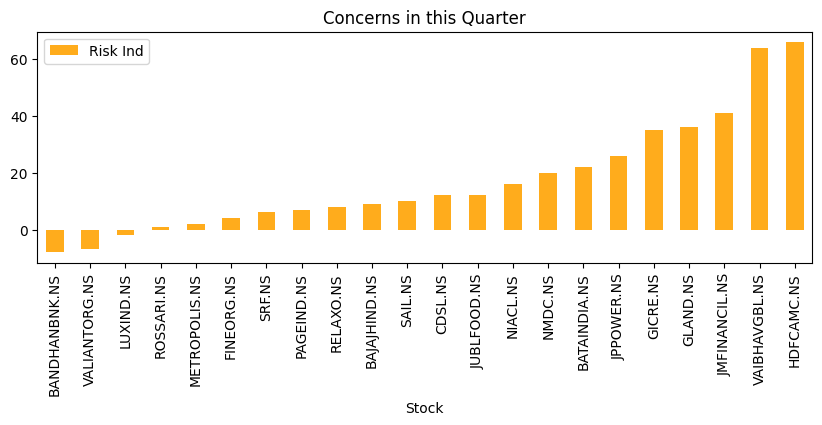

In [12]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)].sort_values(by = 'Risk Ind', ascending=True)
print('qualified stocks: '+str(tmp_df.shape[0]))
tmp_df.plot.bar(y='Risk Ind', x = 'Stock',  figsize=(10, 3), color='#FFAC1C', title='Concerns in this Quarter')

In [13]:
def plot_features_top_bottom(df_portfolio_features, column):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=False).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock',  figsize=(10, 3), color='#4CBB17', title='Top 5 in ' + column, ax=ax1)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=True).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock', figsize=(10, 3), color='#FFAC1C', title='Bottom 5 in ' + column, ax=ax2)

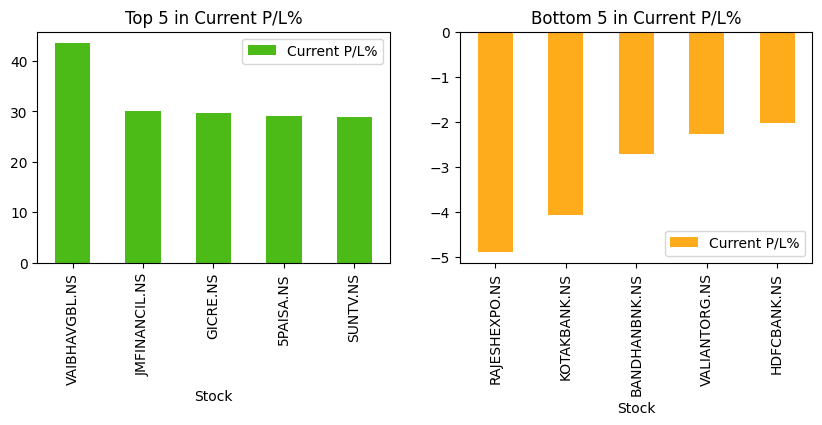

In [14]:
col = 'Current P/L%'
plot_features_top_bottom(df_portfolio_features, col)

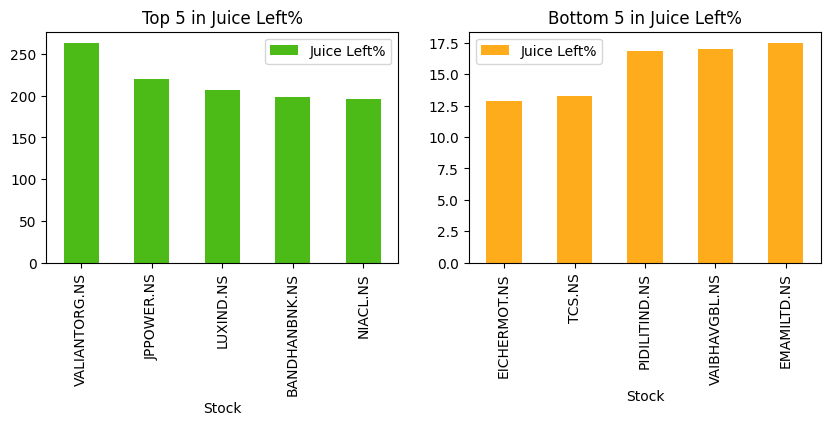

In [15]:
col = 'Juice Left%'
plot_features_top_bottom(df_portfolio_features, col)

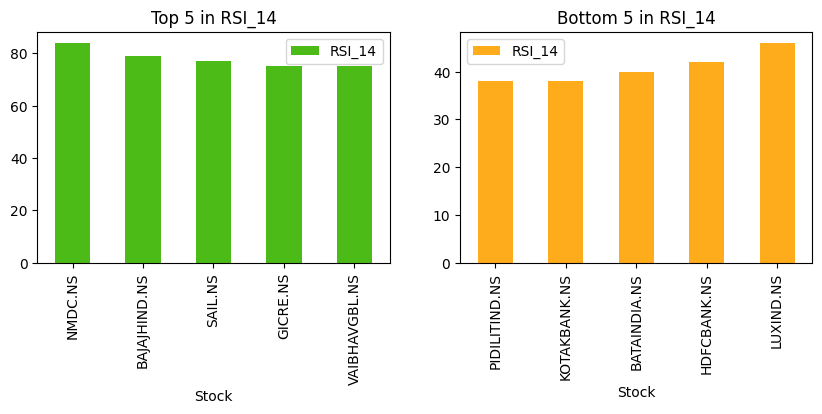

In [16]:
col = 'RSI_14'
plot_features_top_bottom(df_portfolio_features, col)

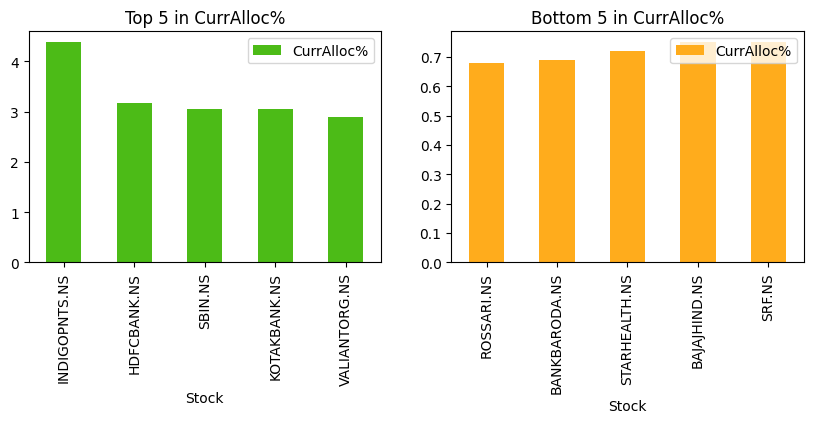

In [17]:
col = 'CurrAlloc%'
plot_features_top_bottom(df_portfolio_features, col)

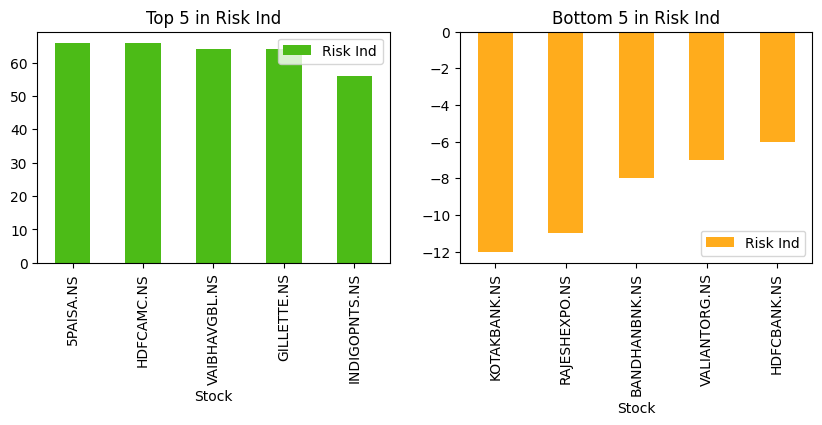

In [18]:
col = 'Risk Ind'
plot_features_top_bottom(df_portfolio_features, col)

In [19]:
def plot_feature_weights(df_portfolio_features, column):
  tmp_df = df_portfolio_features.groupby(column)['CurrAlloc%'].agg(['sum'])
  tmp_df = tmp_df.rename({'sum': 'CurrAlloc%'}, axis='columns')
  tmp_df = tmp_df.sort_values(by = 'CurrAlloc%', ascending=False)
  tmp_df.plot.pie(y='CurrAlloc%', autopct='%1.0f%%', figsize=(5, 5), legend=False, title='CurrAlloc% in ' + column)

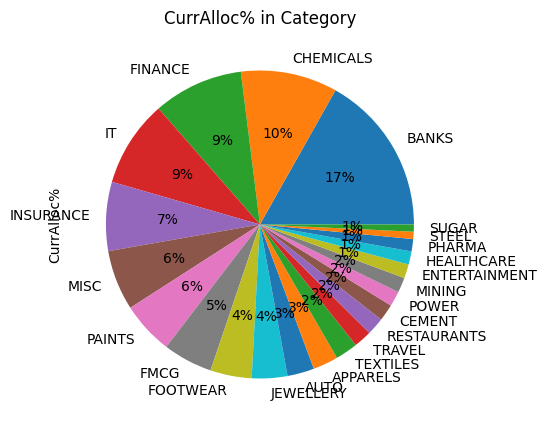

In [20]:
col = 'Category'
plot_feature_weights(df_portfolio_features, col)

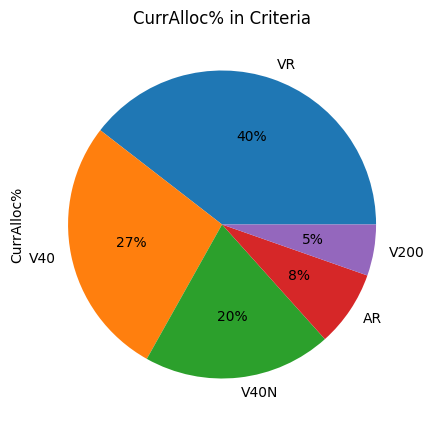

In [21]:
col = 'Criteria'
plot_feature_weights(df_portfolio_features, col)

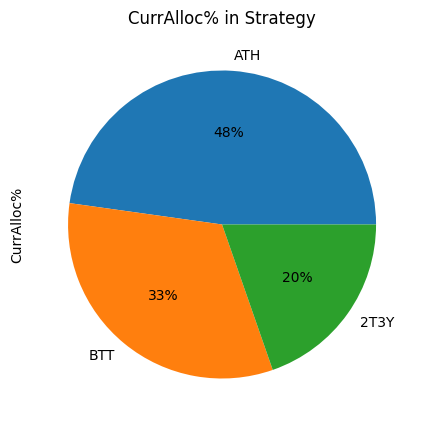

In [22]:
col = 'Strategy'
plot_feature_weights(df_portfolio_features, col)

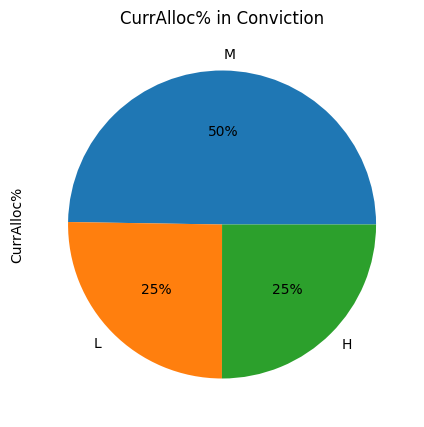

In [23]:
col = 'Conviction'
plot_feature_weights(df_portfolio_features, col)

In [24]:
data_table.DataTable(df_portfolio_features, include_index=False)

,Stock,Close,Dev%_200,RSI_14,Target,Shares,Current,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,CurrAlloc%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
0,5PAISA.NS,448.0,31.81,53.0,553.0,228.0,102144.0,-0.22,29.08,59.34,30.26,2.27,66.0,1,1.0,V40N,ATH,M,FINANCE
1,AAVAS.NS,1646.0,-2.17,67.0,1915.0,37.0,60902.0,1.17,13.21,31.71,18.50,1.35,18.0,1,1.0,VR,BTT,M,FINANCE
2,AMARAJABAT.NS,625.0,2.77,46.0,996.0,120.0,75000.0,-0.16,-0.09,59.22,59.31,1.67,-0.0,1,1.0,V200,ATH,M,AUTO
3,AMBUJACEM.NS,441.0,0.49,48.0,581.0,180.0,79380.0,1.61,4.00,37.02,33.02,1.77,7.0,0,0.0,VR,ATH,L,CEMENT
4,BAJAJFINSV.NS,1510.0,3.57,50.0,1905.0,52.0,78520.0,-0.26,3.79,30.93,27.14,1.75,7.0,1,1.0,V40,ATH,H,FINANCE
5,BAJAJHIND.NS,28.0,89.00,79.0,40.0,1200.0,33600.0,12.00,11.78,59.68,47.90,0.75,9.0,1,0.0,VR,BTT,M,SUGAR
6,BANDHANBNK.NS,236.0,2.27,59.0,718.0,527.0,124372.0,0.43,-2.72,195.96,198.68,2.77,-8.0,1,0.0,VR,2T3Y,M,BANKS
7,BANKBARODA.NS,195.0,10.42,55.0,230.0,160.0,31200.0,2.09,2.77,21.21,18.44,0.69,2.0,1,1.0,VR,BTT,H,BANKS
8,BATAINDIA.NS,1655.0,5.42,40.0,2156.0,70.0,115850.0,-1.72,8.62,41.51,32.89,2.58,22.0,1,0.0,V40,ATH,H,FOOTWEAR
9,BAYERCROP.NS,4831.0,10.09,64.0,5924.0,16.0,77296.0,0.86,11.15,36.29,25.14,1.72,19.0,1,1.0,V40N,ATH,M,CHEMICALS


In [25]:
# stocks to buy in Mom's account

df_data = df_portfolio_features[~df_portfolio_features["Stock"].isin(sv_pf['Stock'].values)]
data_table.DataTable(df_data, include_index=False)


,Stock,Close,Dev%_200,RSI_14,Target,Shares,Current,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,CurrAlloc%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
0,5PAISA.NS,448.0,31.81,53.0,553.0,228.0,102144.0,-0.22,29.08,59.34,30.26,2.27,66.0,1,1.0,V40N,ATH,M,FINANCE
1,AAVAS.NS,1646.0,-2.17,67.0,1915.0,37.0,60902.0,1.17,13.21,31.71,18.50,1.35,18.0,1,1.0,VR,BTT,M,FINANCE
3,AMBUJACEM.NS,441.0,0.49,48.0,581.0,180.0,79380.0,1.61,4.00,37.02,33.02,1.77,7.0,0,0.0,VR,ATH,L,CEMENT
4,BAJAJFINSV.NS,1510.0,3.57,50.0,1905.0,52.0,78520.0,-0.26,3.79,30.93,27.14,1.75,7.0,1,1.0,V40,ATH,H,FINANCE
5,BAJAJHIND.NS,28.0,89.00,79.0,40.0,1200.0,33600.0,12.00,11.78,59.68,47.90,0.75,9.0,1,0.0,VR,BTT,M,SUGAR
8,BATAINDIA.NS,1655.0,5.42,40.0,2156.0,70.0,115850.0,-1.72,8.62,41.51,32.89,2.58,22.0,1,0.0,V40,ATH,H,FOOTWEAR
9,BAYERCROP.NS,4831.0,10.09,64.0,5924.0,16.0,77296.0,0.86,11.15,36.29,25.14,1.72,19.0,1,1.0,V40N,ATH,M,CHEMICALS
10,BERGEPAINT.NS,708.0,14.35,54.0,843.0,72.0,50976.0,-1.67,1.49,20.84,19.35,1.13,2.0,1,1.0,V40,BTT,M,PAINTS
12,CDSL.NS,1152.0,7.93,50.0,1625.0,70.0,80640.0,0.96,6.44,50.15,43.71,1.79,12.0,1,0.0,VR,ATH,L,MISC
13,CLEAN.NS,1438.0,1.52,67.0,2642.0,39.0,56082.0,1.84,5.34,93.54,88.20,1.25,7.0,1,1.0,VR,2T3Y,L,CHEMICALS


In [26]:
#myts['Value'] = myts['Value'].str.replace(',', '').astype(float)

In [27]:
#sum(myts[(myts['Type'] == 'Buy')]['Value'])

In [28]:
#sum(myts[(myts['Type'] == 'Sell')]['Value'])